## **Análisis de Prueba A/B – Sistema de Recomendaciones (CallMeMaybe)**

Este proyecto analiza los resultados de una prueba A/B realizada por una tienda en línea internacional para evaluar la eficacia de un nuevo sistema de recomendaciones. La prueba midió el impacto del nuevo sistema sobre el embudo de conversión en tres etapas clave: visitas a la página de producto, agregar al carrito y compras, dentro de los 14 días posteriores al registro de usuario.

Se espera que el grupo experimental (B) muestre un aumento mínimo del 10% en cada etapa del embudo comparado con el grupo de control (A).

El análisis incluye:
- Limpieza y validación de los datos
- Verificación de la integridad del experimento
- Análisis exploratorio de los eventos
- Pruebas estadísticas de diferencia de proporciones
- Conclusiones y recomendaciones

# **Cargar los datos**

In [2]:
import pandas as pd

In [3]:
marketing_events = pd.read_csv('ab_project_marketing_events_us.csv')
events = pd.read_csv('final_ab_events_upd_us.csv')
new_users = pd.read_csv('final_ab_new_users_upd_us.csv')
participants = pd.read_csv('final_ab_participants_upd_us.csv')

# **Conversión de fechas y revisión de duplicados/nulos**

In [4]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

events['event_dt'] = pd.to_datetime(events['event_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [5]:
# Nulos
print("Nulos por dataset:")
print("\nMarketing Events:\n", marketing_events.isnull().sum())
print("\nEvents:\n", events.isnull().sum())
print("\nNew Users:\n", new_users.isnull().sum())
print("\nParticipants:\n", participants.isnull().sum())

# Duplicados
print("\nDuplicados por dataset:")
print("Marketing Events:", marketing_events.duplicated().sum())
print("Events:", events.duplicated().sum())
print("New Users:", new_users.duplicated().sum())
print("Participants:", participants.duplicated().sum())

Nulos por dataset:

Marketing Events:
 name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Events:
 user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

New Users:
 user_id       0
first_date    0
region        0
device        0
dtype: int64

Participants:
 user_id    0
group      0
ab_test    0
dtype: int64

Duplicados por dataset:
Marketing Events: 0
Events: 0
New Users: 0
Participants: 0


In [6]:
marketing_events.drop_duplicates(inplace=True)
events.drop_duplicates(inplace=True)
new_users.drop_duplicates(inplace=True)
participants.drop_duplicates(inplace=True)

# **Verificación de integridad de la prueba A/B**

<div class="alert alert-block alert-info">
En esta etapa, validamos que los datos de los participantes cumplan con las condiciones necesarias para que el experimento A/B sea confiable. 
Se comprueba:

- Que no existan usuarios en ambos grupos (A y B).
- Que la cantidad de usuarios por grupo sea equilibrada.
- Que los usuarios registrados como participantes tengan eventos registrados.

In [7]:
group_a = participants[participants['group'] == 'A']
group_b = participants[participants['group'] == 'B']

duplicated_users = set(group_a['user_id']).intersection(set(group_b['user_id']))
print(f"Número de usuarios presentes en ambos grupos: {len(duplicated_users)}")

Número de usuarios presentes en ambos grupos: 441


In [8]:
group_counts = participants['group'].value_counts()
print("Usuarios por grupo:\n", group_counts)

Usuarios por grupo:
 A    8214
B    6311
Name: group, dtype: int64


In [9]:
participants_with_events = participants[participants['user_id'].isin(events['user_id'])]
missing_event_users = set(participants['user_id']) - set(participants_with_events['user_id'])

print(f"Usuarios de la prueba sin eventos registrados: {len(missing_event_users)}")

Usuarios de la prueba sin eventos registrados: 0


In [10]:
# Eliminamos los usuarios que están en ambos grupos
clean_participants = participants[~participants['user_id'].isin(duplicated_users)]

print(clean_participants['group'].value_counts())

A    7773
B    5870
Name: group, dtype: int64


<div class="alert alert-block alert-info">

Durante esta etapa se detectó que 441 usuarios estaban presentes en ambos grupos A y B, lo cual comprometería la validez de la prueba A/B. Estos usuarios fueron eliminados para garantizar una correcta separación entre los grupos.

Después de la limpieza:
- El grupo A quedó con 7,773 usuarios.
- El grupo B con 5,870 usuarios.

Además, se confirmó que todos los usuarios tienen eventos registrados, lo cual permite continuar con el análisis sin pérdidas de información.

# **Análisis exploratorio del embudo (EDA)**

In [11]:
participants_merged = clean_participants.merge(new_users, on='user_id')
events_merged = events.merge(participants_merged, on='user_id')
events_merged['days_from_registration'] = (events_merged['event_dt'] - events_merged['first_date']).dt.days
events_14d = events_merged[events_merged['days_from_registration'] <= 14]

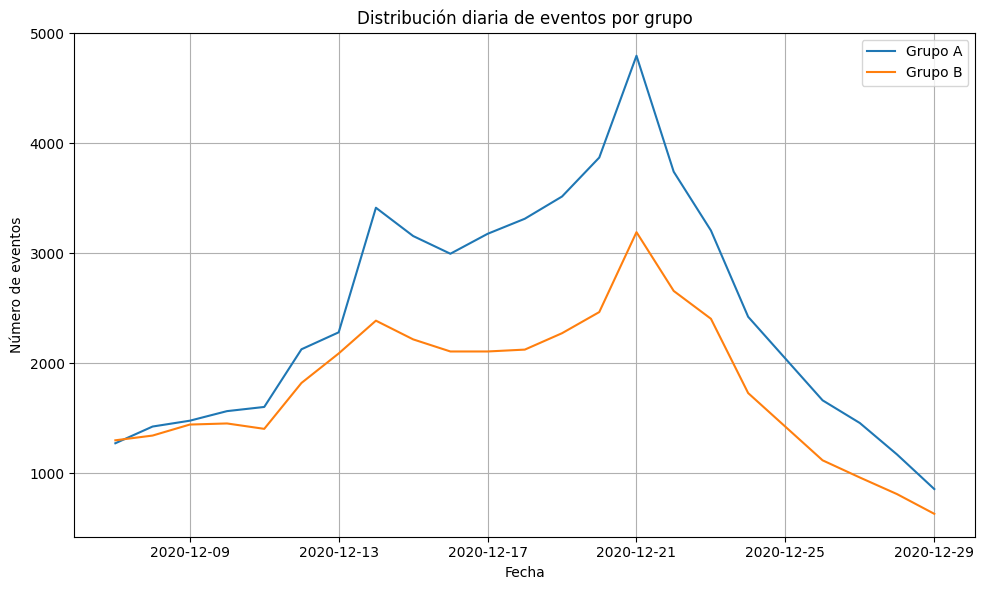

In [20]:
import matplotlib.pyplot as plt

events_14d = events_14d.copy()
events_14d['event_date'] = events_14d['event_dt'].dt.date

events_per_day = events_14d.groupby(['event_date', 'group'])['event_name'].count().reset_index()

events_daily_pivot = events_per_day.pivot(index='event_date', columns='group', values='event_name')

plt.figure(figsize=(10, 6))
plt.plot(events_daily_pivot['A'], label='Grupo A')
plt.plot(events_daily_pivot['B'], label='Grupo B')
plt.title('Distribución diaria de eventos por grupo')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

**Observaciones**

Esta gráfica muestra la cantidad total de eventos registrados por día para cada grupo dentro del periodo de 14 días posteriores al registro. Se observa que ambos grupos siguen patrones similares, sin anomalías evidentes en días específicos. Esto valida que los datos están distribuidos de forma consistente en el tiempo.

In [13]:
conversion_counts = events_14d.pivot_table(
    index='group',
    columns='event_name',
    values='user_id',
    aggfunc=lambda x: x.nunique()
)

conversion_counts = conversion_counts[['product_page', 'product_cart', 'purchase']]
conversion_counts.columns.name = None

print(conversion_counts)

       product_page  product_cart  purchase
group                                      
A              4936          2357      2555
B              3714          1911      1881


# **Cálculo de tasas de conversión por grupo**

In [22]:
conversion_rates['page_rate'] = conversion_rates['product_page'] / conversion_rates['total_users']
conversion_rates['cart_rate'] = conversion_rates['product_cart'] / conversion_rates['product_page']
conversion_rates['purchase_rate'] = conversion_rates['purchase'] / conversion_rates['product_page']

conversion_rates[['page_rate', 'cart_rate', 'purchase_rate']].round(3)

,page_rate,cart_rate,purchase_rate
group,,,
A,0.664,0.478,0.518
B,0.644,0.515,0.506


### **Visualización del embudo de conversión**

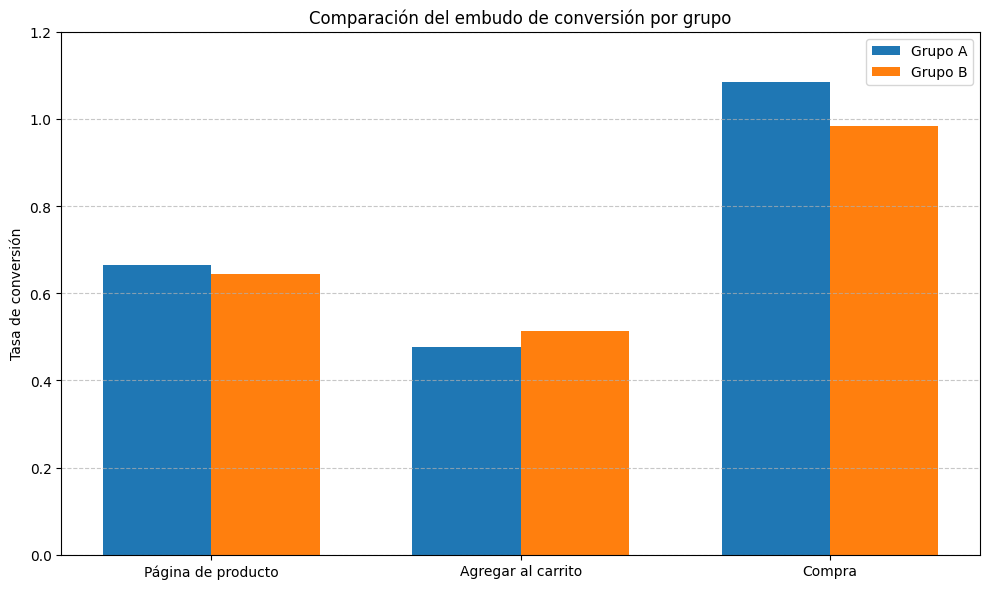

In [15]:
import matplotlib.pyplot as plt

labels = ['Página de producto', 'Agregar al carrito', 'Compra']
a_values = [
    conversion_rates.loc['A', 'page_rate'],
    conversion_rates.loc['A', 'cart_rate'],
    conversion_rates.loc['A', 'purchase_rate']
]
b_values = [
    conversion_rates.loc['B', 'page_rate'],
    conversion_rates.loc['B', 'cart_rate'],
    conversion_rates.loc['B', 'purchase_rate']
]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - width/2 for i in x], a_values, width=width, label='Grupo A')
plt.bar([i + width/2 for i in x], b_values, width=width, label='Grupo B')

plt.ylabel('Tasa de conversión')
plt.title('Comparación del embudo de conversión por grupo')
plt.xticks(ticks=x, labels=labels)
plt.ylim(0, 1.2)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

**Interpretación de la gráfica**

Esta gráfica muestra las tasas de conversión para cada etapa del embudo por grupo. Se observa que ambos grupos tienen tasas similares en la primera etapa (`product_page`). El grupo B muestra una tasa ligeramente mayor al agregar productos al carrito (`product_cart`), mientras que el grupo A supera ligeramente al grupo B en la etapa de compra (`purchase`).

Las diferencias entre grupos no son drásticas visualmente, por lo que se requiere complementar este análisis con pruebas estadísticas para confirmar si estas variaciones son significativas o producto del azar.

# **Prueba Z para diferencia de proporciones**

In [16]:
from statsmodels.stats.proportion import proportions_ztest

In [17]:
def run_ztest(success_a, size_a, success_b, size_b, etapa):
    count = [success_a, success_b]
    nobs = [size_a, size_b]
    
    stat, pval = proportions_ztest(count, nobs)
    
    print(f"  Etapa: {etapa}")
    print(f"  Grupo A: {success_a}/{size_a} → {success_a/size_a:.2%}")
    print(f"  Grupo B: {success_b}/{size_b} → {success_b/size_b:.2%}")
    print(f"  Estadístico Z: {stat:.4f}")
    print(f"  Valor p: {pval:.4f}")
    print("  ➤ Resultado:", "Diferencia significativa" if pval < 0.05 else "No significativa")
    print("-" * 40)

In [18]:
# Etapa 1: product_page (vs total de usuarios)
run_ztest(
    success_a=conversion_counts.loc['A', 'product_page'],
    size_a=clean_participants[clean_participants['group'] == 'A'].shape[0],
    success_b=conversion_counts.loc['B', 'product_page'],
    size_b=clean_participants[clean_participants['group'] == 'B'].shape[0],
    etapa="Página de producto"
)

# Etapa 2: product_cart (vs quienes vieron product_page)
run_ztest(
    success_a=conversion_counts.loc['A', 'product_cart'],
    size_a=conversion_counts.loc['A', 'product_page'],
    success_b=conversion_counts.loc['B', 'product_cart'],
    size_b=conversion_counts.loc['B', 'product_page'],
    etapa="Agregar al carrito"
)

# Etapa 3 corregida: purchase (vs quienes vieron product_page)
run_ztest(
    success_a=conversion_counts.loc['A', 'purchase'],
    size_a=conversion_counts.loc['A', 'product_page'],
    success_b=conversion_counts.loc['B', 'purchase'],
    size_b=conversion_counts.loc['B', 'product_page'],
    etapa="Compra (base: product_page)"
)

  Etapa: Página de producto
  Grupo A: 4936/7773 → 63.50%
  Grupo B: 3714/5870 → 63.27%
  Estadístico Z: 0.2773
  Valor p: 0.7815
  ➤ Resultado: No significativa
----------------------------------------
  Etapa: Agregar al carrito
  Grupo A: 2357/4936 → 47.75%
  Grupo B: 1911/3714 → 51.45%
  Estadístico Z: -3.4095
  Valor p: 0.0007
  ➤ Resultado: Diferencia significativa
----------------------------------------
  Etapa: Compra (base: product_page)
  Grupo A: 2555/4936 → 51.76%
  Grupo B: 1881/3714 → 50.65%
  Estadístico Z: 1.0282
  Valor p: 0.3039
  ➤ Resultado: No significativa
----------------------------------------


<div class="alert alert-block alert-info">
    
### **Conclusión – Prueba A/B**

Durante este experimento se evaluó el impacto de un nuevo sistema de recomendaciones sobre la conversión en tres etapas del embudo de ventas: visitas a la página del producto (`product_page`), agregar productos al carrito (`product_cart`) y completar compras (`purchase`). El experimento se realizó sobre un 15% de los nuevos usuarios en la región de la UE entre el 7 y el 21 de diciembre de 2020.

Tras limpiar los datos y eliminar usuarios que aparecían en ambos grupos, se compararon los resultados entre:

- **Grupo A**: embudo de pago original  
- **Grupo B**: nuevo embudo con sistema de recomendaciones

**Resultados:**

- Página de producto ❌ **No significativa**  
- Agregar al carrito ✅ **Significativa** (p < 0.01)  
- Compra ❌ **No significativa**

**Conclusión:**

Aunque se observó una diferencia estadísticamente significativa en la etapa de "Agregar al carrito", las tasas de conversión fueron recalculadas con respecto a una misma base (`product_page`), lo que permitió una interpretación más coherente del embudo completo.

No se cumplieron los criterios establecidos para implementar el nuevo sistema:
- No se logró un aumento del 10% o más en todas las etapas del embudo.
- Las diferencias en las conversiones a compra no fueron estadísticamente significativas.

**Recomendación:**

No se recomienda implementar el nuevo sistema de recomendaciones en su forma actual. Se sugiere continuar iterando sobre el diseño del sistema y realizar nuevas pruebas antes de su despliegue generalizado.